# LAB 2.3 - Pairwise classification

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink() 

replicating local resources


In [68]:
from local.lib.rlxmoocapi import submit, session
import inspect
student = session.Session(init.endpoint).login( course_id=init.course_id, lab_id="L02.03" )

username: davida.torres@udea.edu.co
password: ··········
using session UDEA


## LAB SUMMARY

In this lab we will use define a **slightly different** machine learning task. Given two MNIST images **as input** we want a network with a binary output: `1` if both images belong to the same MNIST class, and `0` otherwise.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline

In [ ]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=(mnist[:,1:785]/255.).astype(np.float32)
y=(mnist[:,0]).astype(int)
print("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


In [36]:
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.3)
Xtr.shape, ytr.shape, Xts.shape, yts.shape

((1050, 784), (1050,), (450, 784), (450,))

**FIRST**, observe how we build a labelled dataset for this task, so that each training example has:

- two images selected randomly from the original dataset
- label `0` if they belong to the same class, or `1` otherwise

This way, the resulting data structures

- `pXtr` and `pXts` contain the paired images, for train and for test
- `pytr` and `pyts` contain the labels of the corresponding paired images, for train and for test
- `eytr` and `eyts` contain the `0`/`1` new labels, one for each pair.

In [ ]:
def pairup(X, y, n_pairs_per_class, same_class):
    
    idxs = None
    labels = np.unique(y)
    for i in labels:
        idxs_p1 = np.argwhere(y==i)[:,0] if same_class else np.argwhere(y!=i)[:,0]
        idxs_p2 = np.argwhere(y==i)[:,0]
        c = np.vstack([
                    np.random.choice(idxs_p1, size=n_pairs_per_class, replace=True),
                    np.random.choice(idxs_p2, size=n_pairs_per_class, replace=True)
            ]).T
        
        idxs = c if idxs is None else np.vstack((idxs,c))
        
    X_pairs = [X[idxs[:,0]],X[idxs[:,1]]]
    y_pairs = [y[idxs[:,0]],y[idxs[:,1]]]
    y_labels = y[idxs[:,0]]==y[idxs[:,1]]        
        
    return idxs, X_pairs, y_pairs, y_labels

def build_image_pairs(X,y,n_pairs_per_class):
    idxs0, pX0, py0, ey0 = pairup(X, y, n_pairs_per_class, same_class=False)
    idxs1, pX1, py1, ey1 = pairup(X, y, n_pairs_per_class, same_class=True)
    
    pX = [np.vstack((i,j)) for i,j in zip(pX0, pX1)]
    py = [np.hstack((i,j)) for i,j in zip(py0, py1)]
    ey = np.hstack((ey0, ey1))
    idxs = np.vstack((idxs0, idxs1))
    
    return idxs, pX, py, ey.astype(int)
    

In [ ]:
itr, pXtr, pytr, eytr = build_image_pairs(Xtr, ytr, n_pairs_per_class=100)
its, pXts, pyts, eyts = build_image_pairs(Xts, yts, n_pairs_per_class=100)

understand and inspect the structures created and observe how the function above creates a **balanced** dataset


In [ ]:

[i.shape for i in pXtr], [i.shape for i in pytr], itr.shape, eytr.shape


([(2000, 784), (2000, 784)], [(2000,), (2000,)], (2000, 2), (2000,))

In [ ]:

[i.shape for i in pXts], [i.shape for i in pyts], its.shape, eyts.shape


([(2000, 784), (2000, 784)], [(2000,), (2000,)], (2000, 2), (2000,))

In [ ]:

print ("class distribution %.2f::%.2f"%(np.mean(eytr), 1-np.mean(eytr)))



class distribution 0.50::0.50


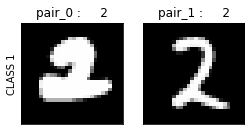

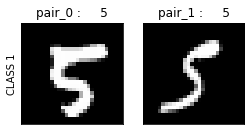

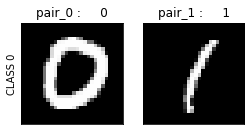

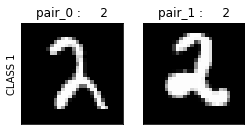

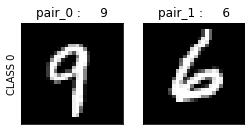

In [ ]:

for _ in range(5):
    i = np.random.randint(len(pXtr[0]))
    plt.figure(figsize=(4,2))
    plt.subplot(121)
    plt.imshow(pXtr[0][i].reshape(28,28), cmap=plt.cm.Greys_r); 
    plt.ylabel("CLASS %d"%(eytr[i]));
    plt.title("pair_0 :     %d"%(pytr[0][i])); plt.xticks([],[]); plt.yticks([],[])
    plt.subplot(122)
    plt.imshow(pXtr[1][i].reshape(28,28), plt.cm.Greys_r); 
    plt.title("pair_1 :     %d"%pytr[1][i]); plt.xticks([],[]); plt.yticks([],[])


## TASK 1: Multi-input model

Create a model with the architecture depicted in the following figure. 

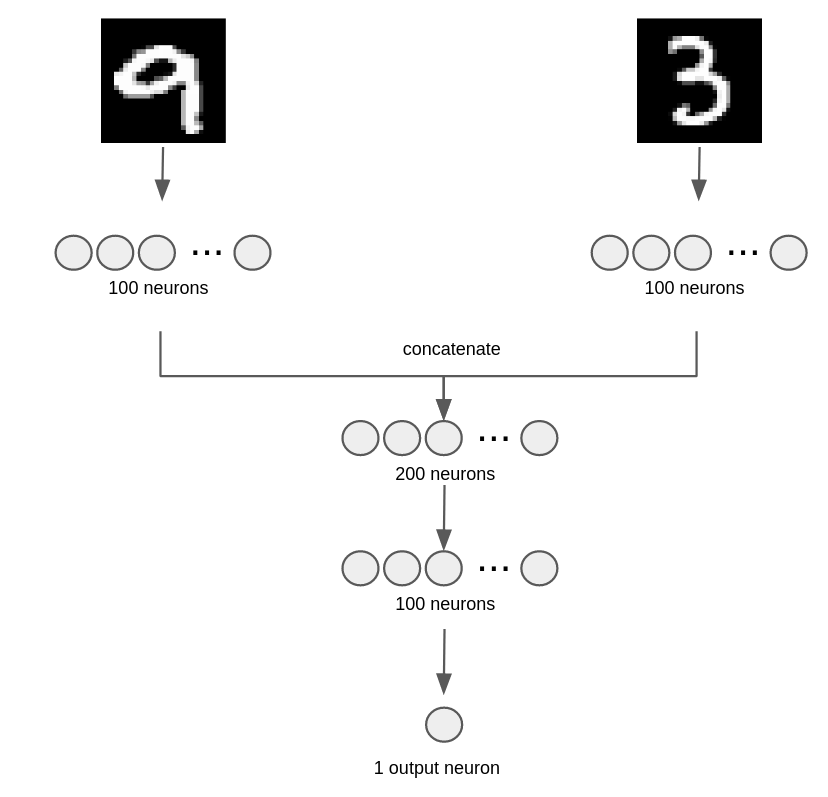

In [ ]:

from IPython.display import Image
Image(filename='local/imgs/twoinputs.png', width=600)


Observe that 

- it will have **TWO** input layers with `input_dim=784` neurons each.
- there is ony **ONE** output neuron.
- the model summary should be as follows and **MUST NAME THE LAYERS ACCORDINGLY**:

<pre>

    __________________________________________________________________________________________________
    Layer (type)                    Output Shape         Param #     Connected to                     
    ==================================================================================================
    input_img0 (InputLayer)         [(None, 784)]        0                                            
    __________________________________________________________________________________________________
    input_img1 (InputLayer)         [(None, 784)]        0                                            
    __________________________________________________________________________________________________
    layer1_img0 (Dense)             (None, 100)          78500       input_img0[0][0]                 
    __________________________________________________________________________________________________
    layer1_img1 (Dense)             (None, 100)          78500       input_img1[0][0]                 
    __________________________________________________________________________________________________
    tf_op_layer_concat_39 (TensorFl [(None, 200)]        0           layer1_img0[0][0]                
                                                                     layer1_img1[0][0]                
    __________________________________________________________________________________________________
    layer2_common (Dense)           (None, 100)          20100       tf_op_layer_concat_39[0][0]      
    __________________________________________________________________________________________________
    output (Dense)                  (None, 1)            101         layer2_common[0][0]              
    ==================================================================================================
    Total params: 177,201
    Trainable params: 177,201
    Non-trainable params: 0
    __________________________________________________________________________________________________
</pre>

In [37]:
def get_model(input_dim):
    
    inputs1  = tf.keras.layers.Input(shape=input_dim, name="input_img0")
    inputs2  = tf.keras.layers.Input(shape=input_dim, name="input_img1")
    
    layer1_img0 = tf.keras.layers.Dense(100,activation="softmax",name = "layer1_img0")(inputs1)
    layer1_img1 = tf.keras.layers.Dense(100,activation="softmax",name = "layer1_img1")(inputs2)
    
    concat_layers = tf.concat([layer1_img0,layer1_img1],axis=1)

    layer2_common = tf.keras.layers.Dense(100,activation="softmax",name = "layer2_common")(concat_layers)
    
    output = tf.keras.layers.Dense(1, activation ="softmax",name="output")(layer2_common)

    model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=output)    
    
    model.compile(optimizer='adam', loss='mse')
    return model

In [38]:
model = get_model(X.shape[1])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img0 (InputLayer)         [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_img1 (InputLayer)         [(None, 784)]        0                                            
__________________________________________________________________________________________________
layer1_img0 (Dense)             (None, 100)          78500       input_img0[0][0]                 
__________________________________________________________________________________________________
layer1_img1 (Dense)             (None, 100)          78500       input_img1[0][0]                 
____________________________________________________________________________________________

**Registra tu solución en linea**

In [ ]:
student.submit_task(namespace=globals(), task_id='T1');

**test your model**

now we can test your model

In [39]:
model = get_model(X.shape[1])
model.fit(pXtr, eytr, batch_size=16, epochs=20)

Epoch 1/20
125/125 [==============================] - 1s 2ms/step - loss: 0.4904
Epoch 2/20
125/125 [==============================] - 0s 2ms/step - loss: 0.4974
Epoch 3/20
125/125 [==============================] - 0s 3ms/step - loss: 0.4972
Epoch 4/20
125/125 [==============================] - 0s 2ms/step - loss: 0.5119
Epoch 5/20
125/125 [==============================] - 0s 3ms/step - loss: 0.4930
Epoch 6/20
125/125 [==============================] - 0s 3ms/step - loss: 0.4945
Epoch 7/20
125/125 [==============================] - 0s 3ms/step - loss: 0.5038
Epoch 8/20
125/125 [==============================] - 0s 2ms/step - loss: 0.4800
Epoch 9/20
125/125 [==============================] - 0s 3ms/step - loss: 0.4979
Epoch 10/20
125/125 [==============================] - 0s 3ms/step - loss: 0.4830
Epoch 11/20
125/125 [==============================] - 0s 3ms/step - loss: 0.4951
Epoch 12/20
125/125 [==============================] - 0s 2ms/step - loss: 0.4933
Epoch 13/20
125/125 [====

In [41]:
preds_ts = (model.predict(pXts)[:,0]>.5).astype(int)
preds_tr = (model.predict(pXtr)[:,0]>.5).astype(int)

In [42]:
print ("accuracy in train data %.2f"%(np.mean(preds_tr==eytr)))
print ("accuracy in test data  %.2f"%(np.mean(preds_ts==eyts)))

accuracy in train data 0.50
accuracy in test data  0.50


inspect TEST predictions. Do you see any class getting more confused with others?

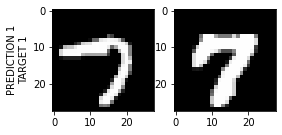

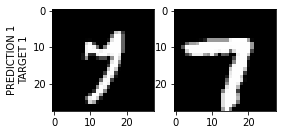

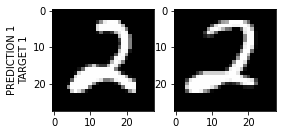

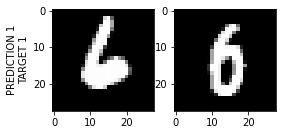

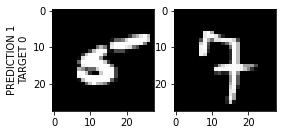

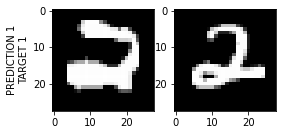

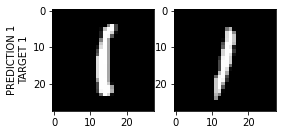

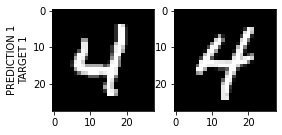

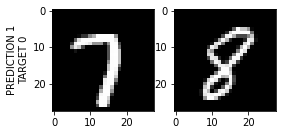

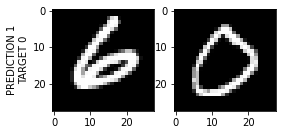

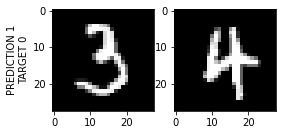

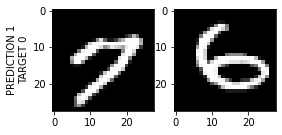

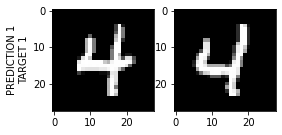

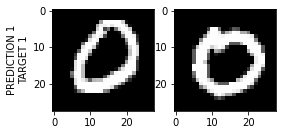

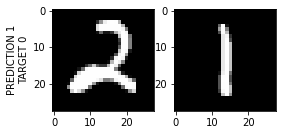

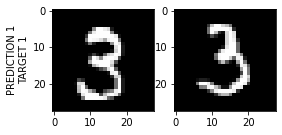

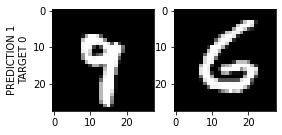

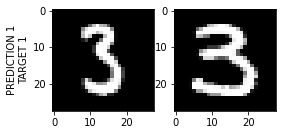

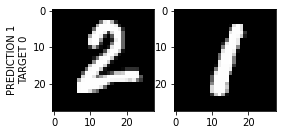

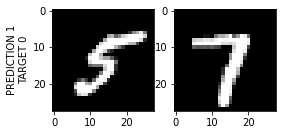

In [43]:
for _ in range(20):
    i = np.random.randint(len(pXts[0]))
    plt.figure(figsize=(4,2))
    plt.subplot(121)
    plt.imshow(pXts[0][i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.ylabel("PREDICTION %d\nTARGET %d"%(preds_ts[i], eyts[i]))
    plt.subplot(122)
    plt.imshow(pXts[1][i].reshape(28,28), cmap=plt.cm.Greys_r)

## TASK 2: Measure per-class accuracy

For each class we want to measure what is the prediction accuracy for the binary task when it participates in a pair. Observe how we gather the labels of each pair together with the binary prediction and the true value.

In [44]:

ts = pd.DataFrame(np.vstack((pyts[0],pyts[1], eyts, preds_ts)).T, columns=["pair_0", "pair_1", "true", "pred"])
ts.head()


,pair_0,pair_1,true,pred
0,7,0,0,1
1,6,0,0,1
2,9,0,0,1
3,1,0,0,1
4,8,0,0,1


of course, the `true` value coincides with `pair_0` being equal or different from `pair_1`.

In [45]:

np.mean((ts.pair_0==ts.pair_1)==ts.true)


1.0

To compute, per-class accuracy in this task, for instance for class 2:

- select the rows where `pair_0` or `pair_1` is 2
- measure the percentage of time in the selected rows where `true==pred`

for instance, for the following DataFrame

            pair_0  pair_1  true  pred
        0        0       0     1     1
        1        0       0     1     1
        2        0       0     1     1
        3        2       2     1     1
        4        1       1     1     1
        5        0       2     0     0
        6        2       2     1     0
        7        2       2     1     1
        8        2       2     1     1
        9        1       1     1     1
        10       1       1     1     1
        11       1       1     1     1
        12       2       2     1     1
        13       0       2     0     1
        14       2       2     1     1
        15       0       0     1     1
        16       2       2     1     1
        17       1       1     1     0
        18       1       1     1     1
        19       1       1     1     1
        
you must return this accuracies:

        {0: 0.8333333333333334, 1: 0.8571428571428571, 2: 0.7777777777777778}


the accuracies must be returned as a dictionary such as above. They keys are the original class labels, and the values the accuracy just described.

The accuracies must be correct up to 3 decimal values.

In [70]:
def perclass_bin_accuracy(ts):
        
    r = {}
    for i in np.unique(ts.pair_0.tolist() + ts.pair_1.tolist()):
        a=ts[(ts.pair_0==i) |(ts.pair_1==i) ] #Indexing rows  with columns with the value of i

        r[i] = len(a[a.true==a.pred])/len(a)

    return r

test your code with the example above

In [64]:
t = pd.DataFrame(
        np.array([[0, 0, 1, 1],[0, 0, 1, 1],[0, 0, 1, 1],[2, 2, 1, 1],[1, 1, 1, 1],
                  [0, 2, 0, 0],[2, 2, 1, 0],[2, 2, 1, 1],[2, 2, 1, 1],[1, 1, 1, 1],[1, 1, 1, 1],[1, 1, 1, 1],
                  [2, 2, 1, 1],[0, 2, 0, 1],[2, 2, 1, 1],[0, 0, 1, 1],[2, 2, 1, 1],[1, 1, 1, 0],[1, 1, 1, 1],
                  [1, 1, 1, 1]]), 
    columns=["pair_0", "pair_1", "true", "pred"])
perclass_bin_accuracy(t)

{0: 0.8333333333333334, 1: 0.8571428571428571, 2: 0.7777777777777778}

0.8333333333333334

test your code with other random examples

In [ ]:
t

In [65]:
n, n_classes = 20, 3
p0 = np.random.randint(n_classes, size=n)
p1 = np.random.randint(n_classes, size=n)
dtrue = (p0==p1).astype(int)
preds = np.random.randint(2, size=n)
td = pd.DataFrame([p0,p1,dtrue,preds], index=["pair_0", "pair_1", "true", "pred"]).T

td

,pair_0,pair_1,true,pred
0,2,1,0,0
1,2,1,0,0
2,0,1,0,0
3,0,1,0,0
4,2,0,0,1
5,0,0,1,1
6,0,2,0,0
7,0,2,0,1
8,0,1,0,1
9,1,2,0,1


In [66]:
perclass_bin_accuracy(td)

{0: 0.8333333333333334, 1: 0.8, 2: 0.8571428571428571}

**Registra tu solución en linea**

In [71]:
student.submit_task(namespace=globals(), task_id='T2');